# Код для классификации чистоты тарелок
Дататсет: https://www.kaggle.com/competitions/platesv2/overview

In [797]:
from torchvision.datasets import ImageFolder
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.transforms import v2
import torchvision as tv

In [798]:
from zipfile import ZipFile

with ZipFile("plates.zip", "r") as myzip:
    myzip.extractall()

In [861]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
])
dataset_train = ImageFolder( 'plates/train', transform=transform)

In [862]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandAugment(3),
    transforms.ToTensor(),
])
for i in range(20):
  dataset_aug = ImageFolder( 'plates/train', transform=transform)
  dataset_train = torch.utils.data.ConcatDataset([dataset_train, dataset_aug])

In [863]:
train_loader = DataLoader(dataset_train, batch_size = 10, shuffle = True)

In [864]:
class_names = ['cleaned','dirty']

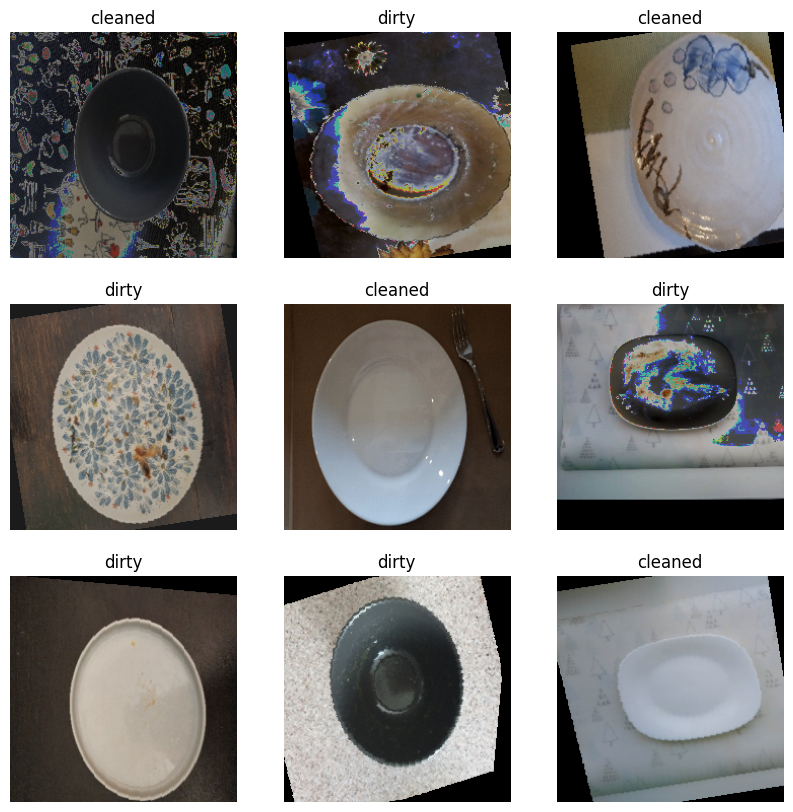

In [865]:
plt.figure(figsize=(10, 10))
for x, y in train_loader:
  for i in range(9):
    img, label = x[i],y[i]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img.permute(1,2,0))
    plt.title(class_names[label])
    plt.axis("off")
  break

In [866]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [867]:
def train(model, epoch):
    train_losses = []
    test_losses = []

    for i in range(epoch):
        model.train()
        losses_epoch_train = []
        losses_epoch_test = []
        y_pred_test = []
        y_true_test = []
        for x_example, y_example in train_loader:
            x_example = x_example.to(device)
            y_example = y_example.to(device)
            y_pred = model(x_example)

            loss = criterion(y_pred, y_example)
            losses_epoch_train.append(loss.cpu().item())
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

        train_losses.append(np.mean(losses_epoch_train))
        print(f'epoch {i}: train_loss = {np.mean(losses_epoch_train):.8f}')
    return model, train_losses, test_losses, y_true_test, y_pred_test

In [881]:
from torchvision.models import resnet50,ResNet50_Weights
model = nn.Sequential()

model.add_module('resnet', resnet50(weights=ResNet50_Weights.IMAGENET1K_V2))

model.add_module('relu_1', nn.ReLU())
model.add_module('fc_1', nn.Linear(1000, 512))
model.add_module('relu_2', nn.ReLU())
model.add_module('fc_2', nn.Linear(512, 2))

In [882]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [883]:
model, train_losses, test_losses, y_true_test, y_pred_test = train(model, 2)

epoch 0: train_loss = 0.22273894
epoch 1: train_loss = 0.03437048


In [884]:
import os
from PIL import Image
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_paths = os.listdir(root_dir)
        self.transform = transform = transforms.Compose([
      transforms.Resize(size=(224, 224)),
      transforms.ToTensor(),
  ])

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_paths[idx])
        image = self.transform(Image.open(img_path).convert('RGB'))
        return image, self.image_paths[idx]

    def __len__(self):
        return len(self.image_paths)

In [885]:
from torch.utils.data import DataLoader

dataset = CustomDataset('plates/test/all')
dataloader = DataLoader(dataset, batch_size=10, shuffle=False)

y_id_list = []
y_pred_list = []
for batch_idx, (images, file_names) in enumerate(dataloader):
    images = images.to(device)
    with torch.no_grad():
      y_pred = model(images)
    y_pred_list.extend(y_pred.cpu())
    y_id_list.extend(file_names)

In [886]:
y_pred_new = [class_names[torch.argmax(y).item()] for y in y_pred_list]
y_id_new = [y.split('.')[0] for y in y_id_list]

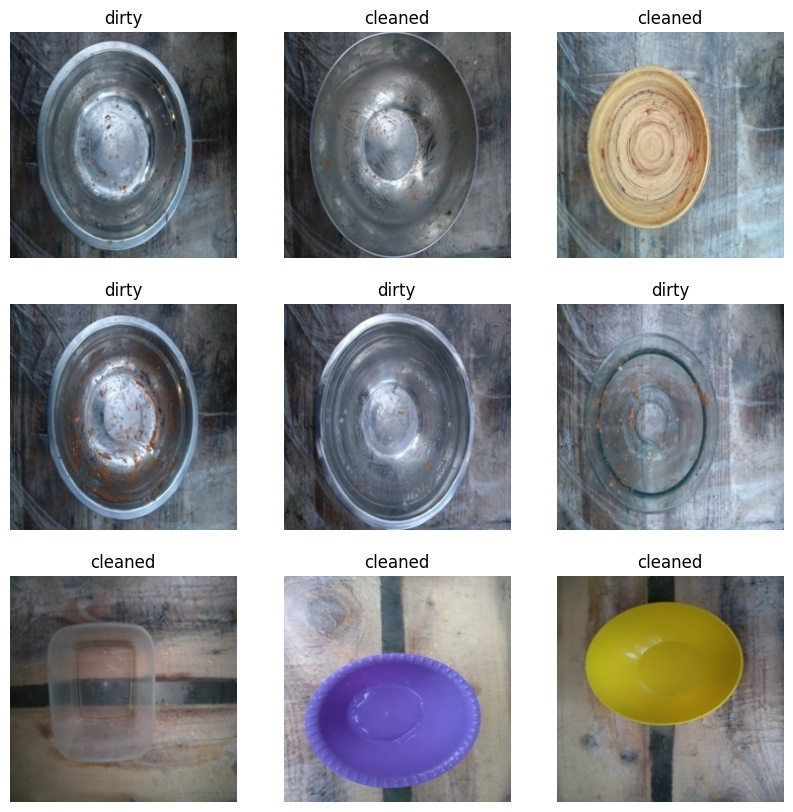

In [887]:
plt.figure(figsize=(10, 10))
for batch_idx, (images, file_names) in enumerate(dataloader):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].permute(1,2,0))
    plt.title(y_pred_new[i])
    plt.axis("off")
  break

In [888]:
import pandas as pd

df = pd.DataFrame({'id':y_id_new,'label':y_pred_new}).sort_values(by=['id'])
df.head()

,id,label
642,0000,dirty
13,0001,cleaned
238,0002,cleaned
606,0003,dirty
397,0004,dirty


In [814]:
df.to_csv('result.csv', index = False)